In [1]:
import numpy as np
import pandas as pd
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.nn import GCNConv
from torch.nn import Linear
from torch_geometric.utils import dense_to_sparse
from torch_geometric.loader import DataLoader
from longrange.range import DiffModel

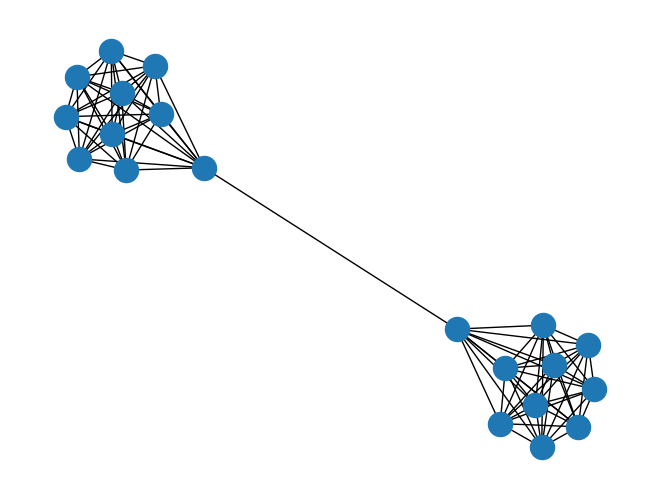

In [2]:
def dumbell_adj(N):
    "Builds adjacency matrix of a dumbell graph"
    A = np.zeros([2*N, 2*N])
    clq = np.ones([N, N]) - np.eye(N)
    A[:N, :N] = clq
    A[N:, N:] = clq
    A[N-1, N] = 1
    A[N, N-1] = 1
    return A

# Plot the dumbell
A = dumbell_adj(10)
G = nx.from_numpy_array(A)
nx.draw(G)

In [3]:
def gen_dumbell_signal(N):
    """ Generate input and output signals for the over-squashing task on the barbell."""
    mu1, mu2 = -np.sqrt(3*N), np.sqrt(3*N)
    std1, std2 = np.sqrt(N), np.sqrt(N)
    x1 = torch.empty([N, 1]).uniform_(mu1 - np.sqrt(3) * std1, mu1 + np.sqrt(3) * std1)
    x2 = torch.empty([N, 1]).uniform_(mu2 - np.sqrt(3) * std2, mu2 + np.sqrt(3) * std2)
    y1, y2 = x2.mean(dim=0).repeat(N, 1), x1.mean(dim=0).repeat(N, 1)
    x = torch.cat((x1, x2), dim=0)
    y = torch.cat((y1, y2), dim=0)
    return x, y


def task_jacobian(N):
    "Builds jacobian  matrix of the task"
    A = np.zeros([2*N, 2*N])
    clq = np.ones([N, N])/N
    A[:N, N:] = clq
    A[N:, :N] = clq
    return A

def generate_data(num_graphs=100, N=10):
    """ Creates a list of torch geometric Data object with dumbell graphs and input/output pairs.
        Unlike Cora, in this dataset we sample the input and output signals several times on the same graph.
    """
    A = dumbell_adj(N)
    edge_index,_ = dense_to_sparse(torch.tensor(A)) # convert to sparse tensor

    data_ls = []
    for i in range(num_graphs):
        x, y = gen_dumbell_signal(N)
        data = torch_geometric.data.Data(x = x, edge_index = edge_index, y = y)
        data_ls += [data]
    return data_ls

In [4]:
# Use above methods to define the train, validation and test data, as well as corresponding data loader. 
# Data loader are necessary since we sample the input and output several times on the graph.
train_data_ls = generate_data(50, N=20)
val_data_ls = generate_data(50, N=20)
test_data_ls = generate_data(50, N=20)
train_data_loader = DataLoader(train_data_ls, batch_size=5)
val_data_loader = DataLoader(val_data_ls, batch_size=5)
test_data_loader = DataLoader(test_data_ls, batch_size=5)

data = next(iter(train_data_loader))
edge_index_batch = data.edge_index
print(data.x.shape)

torch.Size([200, 1])


In [13]:
## Class defining the Graph Convolutional layer
class GCN(torch.nn.Module):

    def __init__(self, dropout=0.0, dim_inner=32):
        super(GCN, self).__init__()
        self.enc = Linear(1, dim_inner)  # encoder 
        self.conv1 = GCNConv(dim_inner, dim_inner) # The first layer map the node features to a 16-dimensional vector.
        self.conv2 = GCNConv(dim_inner, dim_inner) # The second layer output a 16-dimensional vector.
        self.conv3 = GCNConv(dim_inner, dim_inner) # The second layer output a 16-dimensional vector.
        self.regressor = Linear(dim_inner, 1) # The last layer is linear and output class scores.
        self.dropout = dropout

    def forward(self, x, edge_index):
        
        # After each convolutional layer we apply a relu non linear transformation and dropout (optional).
        h = self.enc(x)
        h = h.relu()
        h = torch.nn.functional.dropout(h, p=self.dropout)
        
        h = self.conv1(h, edge_index)
        h = h.relu()
        h = torch.nn.functional.dropout(h, p=self.dropout)

        h = self.conv2(h, edge_index)
        h = h.relu() # node embeddings
        h = torch.nn.functional.dropout(h, p=self.dropout)

        h = self.conv3(h, edge_index)
        h = h.relu() # node embeddings
        h = torch.nn.functional.dropout(h, p=self.dropout)

        # Apply a final (linear) classifier.
        out = self.regressor(h)
        return out

model = GCN()
print("Model architecture:")
print(model)
gcn_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {gcn_total_params}")

Model architecture:
GCN(
  (enc): Linear(in_features=1, out_features=32, bias=True)
  (conv1): GCNConv(32, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (regressor): Linear(in_features=32, out_features=1, bias=True)
)
Number of parameters: 3265


torch.Size([2, 3810])
torch.Size([200, 1, 200, 1])


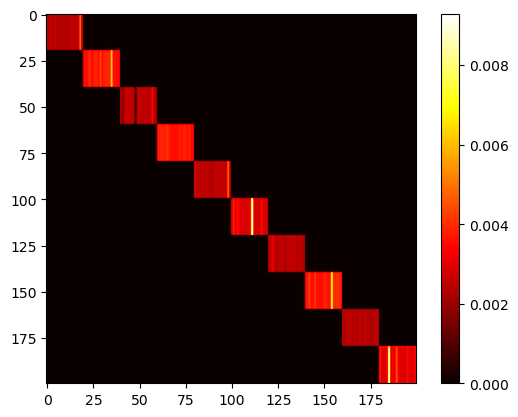

In [14]:
data = next(iter(val_data_loader))
x, edge_index, y = data.x, data.edge_index, data.y
print(edge_index.shape)
diffmodel = DiffModel(model, edge_index)

J = diffmodel.jacobian(x)
print(J.shape)
J = torch.abs(J[:, 0, :, 0])
# Create a figure with two subplots
plt.imshow(J, cmap='hot')
plt.colorbar()  # Add the color scale
plt.show()

In [15]:
criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)  # Define optimizer.
device = "cpu"

def train(data_loader):
    model.train()
    loss_ls = []

    for step, batch in enumerate(data_loader):
        optimizer.zero_grad()  # Clear gradients.
        batch = batch.to(device)
        out = model(x=batch.x, edge_index=batch.edge_index)  # Forward on batch.
        loss = criterion(out, batch.y)  # Compute loss on batch.

        loss.backward()
        optimizer.step()
        loss_ls += [loss.detach()]
    return np.mean(loss_ls)  # average loss

def val(data_loader):
    model.eval()
    loss_ls = []

    for step, batch in enumerate(data_loader):
        batch = batch.to(device)
        out = model(x=batch.x, edge_index=batch.edge_index)  # Forward on batch.
        loss = criterion(out, batch.y)  # Compute loss on batch.
        loss_ls += [loss.detach()]
    return np.mean(loss_ls)  # average loss

d = {"Training_Loss": [], "Validation_Loss": [], "Test_Loss": [], "epoch" : []}
for epoch in range(500):
    loss_mean = train(train_data_loader)
    val_loss = val(val_data_loader)
    test_loss = val(test_data_loader)
    d["Training_Loss"].append(loss_mean)
    d["Validation_Loss"].append(val_loss)
    d["Test_Loss"].append(test_loss)

    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training_Loss {loss_mean}, Validation_Loss {val_loss}")

Epoch 0: Training_Loss 21.578388214111328, Validation_Loss 5.122241020202637
Epoch 10: Training_Loss 2.1362669467926025, Validation_Loss 2.192406177520752
Epoch 20: Training_Loss 1.7500146627426147, Validation_Loss 1.8361068964004517
Epoch 30: Training_Loss 1.4411649703979492, Validation_Loss 1.494893193244934
Epoch 40: Training_Loss 1.2919468879699707, Validation_Loss 1.2730211019515991
Epoch 50: Training_Loss 1.2529525756835938, Validation_Loss 1.2425251007080078
Epoch 60: Training_Loss 1.225102424621582, Validation_Loss 1.204135537147522
Epoch 70: Training_Loss 1.1848297119140625, Validation_Loss 1.169206142425537
Epoch 80: Training_Loss 1.1685633659362793, Validation_Loss 1.1630383729934692
Epoch 90: Training_Loss 1.1737737655639648, Validation_Loss 1.169385552406311
Epoch 100: Training_Loss 1.1457479000091553, Validation_Loss 1.147784948348999
Epoch 110: Training_Loss 1.1465394496917725, Validation_Loss 1.139736533164978
Epoch 120: Training_Loss 1.1354763507843018, Validation_Loss

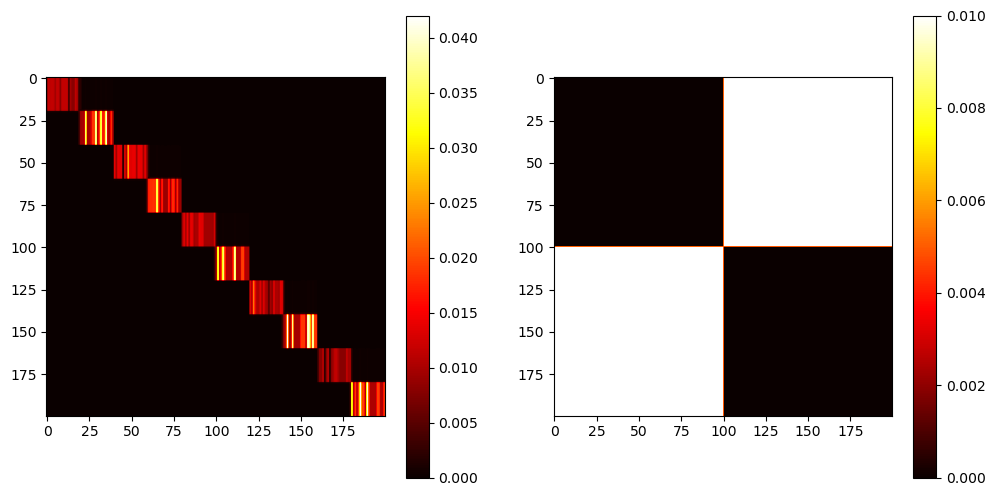

In [16]:
data = next(iter(val_data_loader))
x, edge_index, y = data.x, data.edge_index, data.y
diffmodel.update_model(model)
diffmodel.update_edge_index(edge_index)
J = diffmodel.jacobian(x)
J = torch.abs(J[:, 0, :, 0])
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First image with colorbar
im1 = axs[0].imshow(J, cmap='hot')
fig.colorbar(im1, ax=axs[0])  # Add colorbar to the first subplot

# Second image with colorbar
jac = task_jacobian(x.shape[0] // 2)
im2 = axs[1].imshow(jac, cmap='hot')
fig.colorbar(im2, ax=axs[1])  # Add colorbar to the second subplot

# Show the plot
plt.show()

# Rewiring:

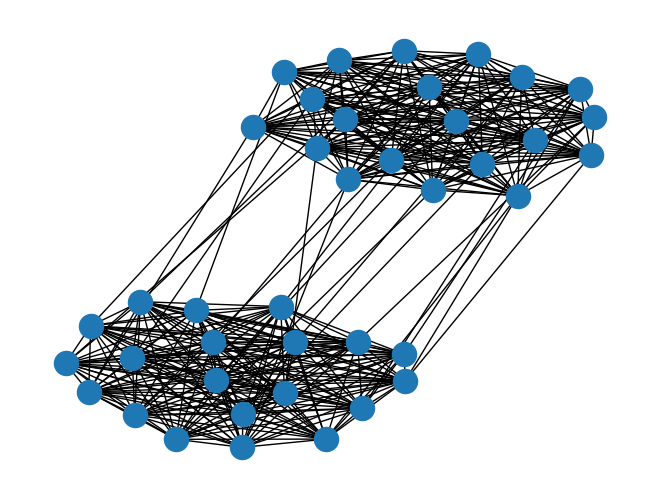

In [17]:
def rewired_dumbell_adj(N):
    "Build adjacency matrix of a dumbell graph"
    A = np.zeros([2*N, 2*N])
    clq = np.ones([N, N]) - np.eye(N)
    A[:N, :N] = clq
    A[N:, N:] = clq
    A[N-1, N] = 1
    A[N, N-1] = 1
    # rewire the graph by adding edges 'parallel' to the bottleneck edge
    for i in range(0, N):
        A[i, N+i] = 1
        A[i+N, i] = 1
    return A

def generate_rewired_data(num_graphs=100, N=10):
    "Create a list of torch geometric Data object with rewired dumbell graph and input/output pairs"
    A = rewired_dumbell_adj(N)
    edge_index,_ = dense_to_sparse(torch.tensor(A))
    data_ls = []
    for i in range(num_graphs):
        x, y = gen_dumbell_signal(N)
        data = torch_geometric.data.Data(x = x, edge_index = edge_index, y = y)
        data_ls += [data]
    return data_ls

# Plot the dumbell
A = rewired_dumbell_adj(20)
G = nx.from_numpy_array(A)
nx.draw(G)

In [18]:
# Build train, val, and test on rewired graph
re_train_data_ls = generate_rewired_data(50, N=20)
re_val_data_ls = generate_rewired_data(50, N=20)
re_test_data_ls = generate_rewired_data(50, N=20)
re_train_data_loader = DataLoader(re_train_data_ls, batch_size=5)
re_val_data_loader = DataLoader(re_val_data_ls, batch_size=5)
re_test_data_loader = DataLoader(re_test_data_ls, batch_size=5)

data = next(iter(re_val_data_loader))
edge_index_batch = data.edge_index
print(edge_index_batch.shape)

model = GCN()
print("Model architecture:")
print(model)
print(edge_index_batch.shape)
gcn_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {gcn_total_params}")

torch.Size([2, 4010])
Model architecture:
GCN(
  (enc): Linear(in_features=1, out_features=32, bias=True)
  (conv1): GCNConv(32, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (regressor): Linear(in_features=32, out_features=1, bias=True)
)
torch.Size([2, 4010])
Number of parameters: 3265


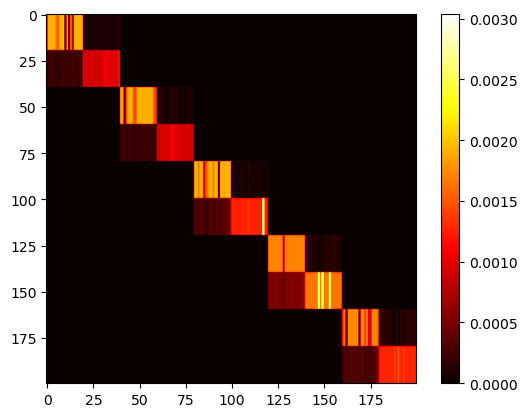

In [19]:
data = next(iter(re_val_data_loader))
x, edge_index, y = data.x, data.edge_index, data.y
diffmodel.update_model(model)
diffmodel.update_edge_index(edge_index)
J = diffmodel.jacobian(x)
J = torch.abs(J[:, 0, :, 0])
# Create a figure with two subplots
plt.imshow(J, cmap='hot')
plt.colorbar()  # Add the color scale
plt.show()

In [21]:
diffmodel.edge_index.shape

torch.Size([2, 4010])

In [22]:
criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)  # Define optimizer.
device = "cpu"

d = {"Training_Loss": [], "Validation_Loss": [], "Test_Loss": [], "epoch" : []}
for epoch in range(500):
    loss_mean = train(re_train_data_loader)
    val_loss = val(re_val_data_loader)
    test_loss = val(re_test_data_loader)
    d["Training_Loss"].append(loss_mean)
    d["Validation_Loss"].append(val_loss)
    d["Test_Loss"].append(test_loss)

    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training_Loss {loss_mean}, Validation_Loss {val_loss}")

Epoch 0: Training_Loss 31.048099517822266, Validation_Loss 8.661001205444336
Epoch 10: Training_Loss 2.1638283729553223, Validation_Loss 2.9535276889801025
Epoch 20: Training_Loss 2.0351150035858154, Validation_Loss 2.8021481037139893
Epoch 30: Training_Loss 1.8475011587142944, Validation_Loss 2.733712673187256
Epoch 40: Training_Loss 1.777968406677246, Validation_Loss 2.1490962505340576
Epoch 50: Training_Loss 1.7504222393035889, Validation_Loss 2.243842601776123
Epoch 60: Training_Loss 1.2910000085830688, Validation_Loss 1.8684810400009155
Epoch 70: Training_Loss 1.052114486694336, Validation_Loss 1.7930980920791626
Epoch 80: Training_Loss 0.9533082246780396, Validation_Loss 1.662762999534607
Epoch 90: Training_Loss 0.8817259669303894, Validation_Loss 2.0138485431671143
Epoch 100: Training_Loss 0.7111238837242126, Validation_Loss 2.08621883392334
Epoch 110: Training_Loss 0.6459931135177612, Validation_Loss 2.4535164833068848
Epoch 120: Training_Loss 0.5631390810012817, Validation_Los

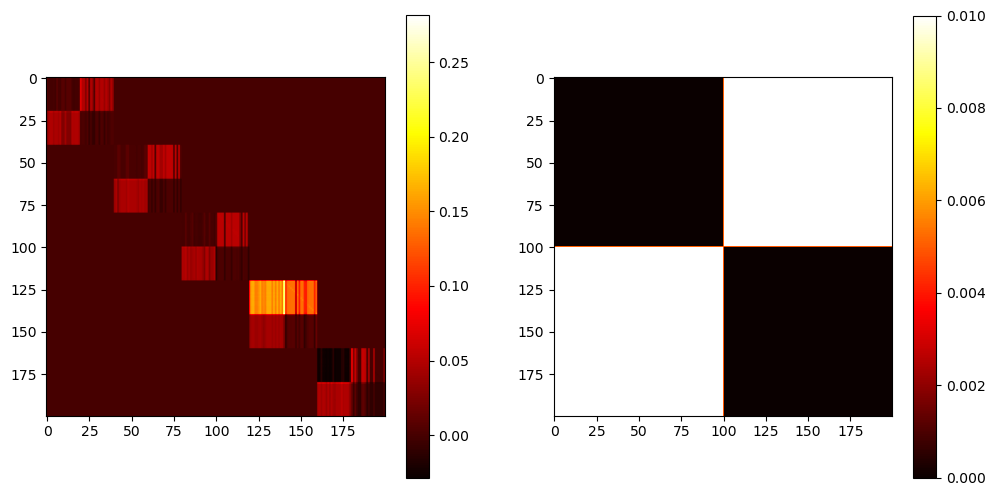

In [26]:
data = next(iter(re_val_data_loader))
x, edge_index, y = data.x, data.edge_index, data.y
diffmodel.update_model(model)
diffmodel.update_edge_index(edge_index)
J = diffmodel.jacobian(x)
J = J[:, 0, :, 0]
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First image with colorbar
im1 = axs[0].imshow(J, cmap='hot')
fig.colorbar(im1, ax=axs[0])  # Add colorbar to the first subplot

# Second image with colorbar
jac = task_jacobian(x.shape[0] // 2)
im2 = axs[1].imshow(jac, cmap='hot')
fig.colorbar(im2, ax=axs[1])  # Add colorbar to the second subplot

# Show the plot
plt.show()